<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

**ОПИСАНИЕ ПРОЕКТА**

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Наша задача спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Решать задачу будем на основе данных о поведении клиентов и расторжении договоров с банком. 

**План работы:**
- Изучим и подготовим данные для работы
- Иследуем данные на предмет дисбаланса классов
- Построим модели без учета дисбаланса классов
- Поборимся с дисбалансом и построим модели с его учетом 
- Проведем тестирование лучшей модели. Задача достичь максимольно большого значения *F1*-меры. Доведем метрику до 0.59.
- Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

**Описание данных:**
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата
- Целевой признак `Exited` — факт ухода клиента


In [1]:
!pip install scikit-learn==1.1.3

In [2]:
!pip install imblearn

## Подготовка данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, recall_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier

In [4]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.5f}'.format)

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00000,0.00000,1,1,1,"101,348.88000",1
1,2,15647311,Hill,608,Spain,Female,41,1.00000,"83,807.86000",1,0,1,"112,542.58000",0
2,3,15619304,Onio,502,France,Female,42,8.00000,"159,660.80000",3,1,0,"113,931.57000",1
3,4,15701354,Boni,699,France,Female,39,1.00000,0.00000,2,0,0,"93,826.63000",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00000,"125,510.82000",1,1,1,"79,084.10000",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,"10,000.00000",NaN,NaN,NaN,"5,000.50000","2,886.89568",1.00000,"2,500.75000","5,000.50000","7,500.25000","10,000.00000"
CustomerId,"10,000.00000",NaN,NaN,NaN,"15,690,940.56940","71,936.18612","15,565,701.00000","15,628,528.25000","15,690,738.00000","15,753,233.75000","15,815,690.00000"
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,"10,000.00000",NaN,NaN,NaN,650.52880,96.65330,350.00000,584.00000,652.00000,718.00000,850.00000
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,"10,000.00000",NaN,NaN,NaN,38.92180,10.48781,18.00000,32.00000,37.00000,44.00000,92.00000
Tenure,"9,091.00000",NaN,NaN,NaN,4.99769,2.89472,0.00000,2.00000,5.00000,7.00000,10.00000
Balance,"10,000.00000",NaN,NaN,NaN,"76,485.88929","62,397.40520",0.00000,0.00000,"97,198.54000","127,644.24000","250,898.09000"
NumOfProducts,"10,000.00000",NaN,NaN,NaN,1.53020,0.58165,1.00000,1.00000,1.00000,2.00000,4.00000


In [7]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [8]:
# Посмотрим распределение уникальных значений в столбцах
feature_names = df.columns.tolist() 
for column in feature_names: 
    print(column) 
    print(df[column].value_counts(dropna=False))

RowNumber
1        1
6671     1
6664     1
6665     1
6666     1
        ..
3334     1
3335     1
3336     1
3337     1
10000    1
Name: RowNumber, Length: 10000, dtype: int64
CustomerId
15634602    1
15667932    1
15766185    1
15667632    1
15599024    1
           ..
15599078    1
15702300    1
15660735    1
15671390    1
15628319    1
Name: CustomerId, Length: 10000, dtype: int64
Surname
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64
CreditScore
850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: CreditScore, Length: 460, dtype: int64
Geography
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
Gender
Male      5457
Female    4543
Name: Gender, dtype: int64
Age
37    478
38    477
35    474
36    456
34    447
     ... 
92  

**После загрузки файла и первичного изучения данных, наблюдается следующее:**
- Файл содержит данные о 10000 клиентах и их 14 признаках. Целевой признак `Exited` - факт ухода клиента.
- Имеется ряд признаков, которые не оказывают влияние на целевой признак. Это `RowNumber`, `CustomerId`, `Surname`. Их можно удалить. 
- Имеются пропуски в столбце `Tenure`, скорее всего, они имеют случайный характер. Их количество достаточно велико, чтобы удалить эти данные. Заполним пропуски медианным значением, чтоб не исказить данные
- Численные признаки необходимо масштабировать, т.к. существует большой разброс значений.
- Категориальные признаки преобразуем методом One-Hot Encoding
 

In [9]:
#Удалим лишние признаки
df.drop(columns=['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [10]:
# Посмотрим как распределены значения в столбце 'Tenure'
df['Tenure'].describe()

count   9,091.00000
mean        4.99769
std         2.89472
min         0.00000
25%         2.00000
50%         5.00000
75%         7.00000
max        10.00000
Name: Tenure, dtype: float64

In [11]:
# Заменим пропуски на случайные значения
df['Tenure']=df['Tenure'].fillna(df['Tenure'].median())

In [12]:
# Посмотрим каким стало распределение после заполнения пропусков
df['Tenure'].describe()

count   10,000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: Tenure, dtype: float64

In [13]:
# Применим ОНЕ-метод к категориальным признакам
#df_ohe = pd.get_dummies(df, drop_first=True)

In [14]:
# Разобьем данные на обучающую, валидационную и тестовую выборки
target = df['Exited']
features = df.drop('Exited', axis=1)
features_train, features_test1, target_train, target_test1 = train_test_split(
    features, target, test_size=0.4, 
    stratify = target, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test1, target_test1, test_size=0.5, 
    stratify = target_test1, random_state=12345)


In [15]:
# Обозначим категориальные признаки для ОНЕ
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['Geography', 'Gender']

In [16]:
# Обозначим численные признаки 
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [17]:
# Закодируем категориальные и стандартизируем численные признаки
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,-1.04043,0.95331,0.36060,0.77466,1,0,1,-0.11911,1.00000,0.00000,0.00000
9925,0.45401,-0.09524,-0.00279,1.91054,1,1,1,-0.25866,0.00000,0.00000,0.00000
8746,0.10359,-0.47654,1.08737,0.48161,2,0,1,1.42284,0.00000,0.00000,1.00000
660,-0.18500,0.19073,-0.00279,0.08844,1,1,1,-1.16043,1.00000,0.00000,0.00000
3610,-0.72093,1.62057,-1.45633,0.87913,1,1,0,0.11324,0.00000,0.00000,0.00000


In [18]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_test[num_features] = scaler.transform(
    features_test[num_features]
)

# смотрим на результат
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
657,-0.50450,1.42993,-1.45633,0.87388,2,1,1,1.72526,1.00000,0.00000,0.00000
2083,-1.19503,-1.42977,-1.45633,-1.21967,1,1,1,1.20366,0.00000,0.00000,1.00000
3234,-1.26718,0.76267,-1.45633,-1.21967,1,1,0,-1.37474,0.00000,0.00000,1.00000
1551,0.82504,1.23928,0.72399,-1.21967,2,0,1,0.38231,0.00000,1.00000,0.00000
2344,0.66014,0.95331,-0.36617,0.26709,1,1,0,-1.61358,1.00000,0.00000,0.00000


In [19]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем валидационную
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем валидационную
features_valid[num_features] = scaler.transform(
    features_valid[num_features]
)

# смотрим на результат
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6612,-1.52484,2.38316,-0.72956,1.01165,1,0,1,0.01027,0.00000,0.00000,0.00000
519,0.58799,1.81122,0.36060,0.21319,1,0,1,0.45309,0.00000,0.00000,1.00000
1609,-0.31898,-0.38121,1.08737,0.89390,1,1,0,-0.60351,0.00000,0.00000,0.00000
3475,1.22699,-0.76251,-0.36617,-0.24036,2,1,1,-1.62146,0.00000,0.00000,1.00000
2707,-0.13346,-0.09524,-0.72956,0.44731,1,0,0,0.33857,0.00000,0.00000,0.00000


**Вывод:**
В результате подготовки данных сделано следующее:
- удалены лишние признаки `RowNumber`, `CustomerId`, `Surname`
- заполнены константой пропуски в столбце `Tenure`
- стандартизированы численные признаки
- категориальные признаки преобразованы методом One-Hot Encoding

## Исследование задачи

0   0.79630
1   0.20370
Name: Exited, dtype: float64


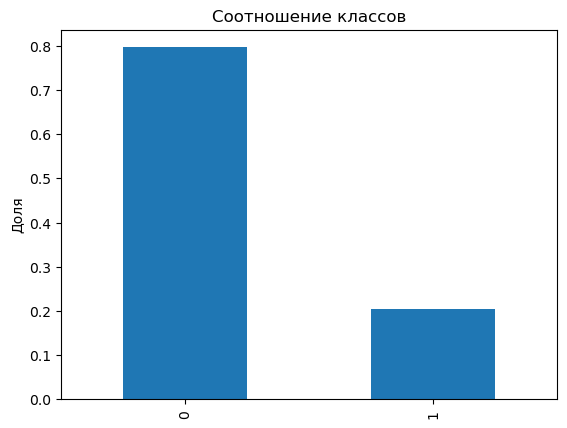

In [20]:
# Посчитаем классы в целевом признаке, сделав их относительными
class_frequency = df['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar',
                     title='Соотношение классов',
                     ylabel='Доля'); 

In [21]:
# Проверим как разделились данные
features_train.shape, features_valid.shape, features_test.shape

((6000, 11), (2000, 11), (2000, 11))

In [22]:
# Посмотрим как распределились по классам
np.bincount(target_train), np.bincount(target_test), np.bincount(target_valid),

(array([4778, 1222], dtype=int64),
 array([1593,  407], dtype=int64),
 array([1592,  408], dtype=int64))

In [23]:
# Посмотрим количество объектов отрицательного и положительного классов
features[target == 0].shape, features[target == 1].shape

((7963, 10), (2037, 10))

Разделение на выборки состоялось в соотношении 3/1/1, пропорция классов в выборках также сохранилась. 

Наблюдается явный дисбаланс классов, объектов отрицательного класса больше, чем положительного в четыре раза. Построим и изучим модели без учета этого дисбаланса.

In [24]:
# Построим и обучим модель решающего дерева
# Подберем лучший параметр глубины в цикле

best_f1_dtc = 0
best_depth_dtc = 0

for depth in range(1,20,1):
    model_dtc = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_dtc.fit(features_train, target_train)
    predicted_dtc = model_dtc.predict(features_valid)
    dtc_f1 = f1_score(target_valid, predicted_dtc)
    if dtc_f1 > best_f1_dtc:
        best_f1_dtc = dtc_f1
        best_depth_dtc = depth
        
print("Лучшее значение f1:", best_f1_dtc)
print("Лучшая глубина дерева:", best_depth_dtc)

Лучшее значение f1: 0.5924855491329479
Лучшая глубина дерева: 7


In [25]:
# Посмотрим значение AUC-ROC для лучшей несбалансированной модели решающего дерева

model_dtc = DecisionTreeClassifier(max_depth=7, random_state=12345)
model_dtc.fit(features_train, target_train)
probabilities_valid = model_dtc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_dtc = roc_auc_score(target_valid, probabilities_one_valid )
print("Значение AUC-ROC для лучшей несбалансированной модели DTC:", auc_roc_dtc)

Значение AUC-ROC для лучшей несбалансированной модели DTC: 0.8230390617302197


У модели решающего дерева пучшее значение `F1 = 0.5924855491329479` при глубине дерева раной `7`

In [26]:
#Построим и обучим модель случайного леса
# Подберем лучший параметр глубины и количества деревьев в цикле

best_f1_rfc = 0
best_est = 0
best_depth_rfc = 0

for est in range(1,20,1):
    for depth in range(1,10,1):
        model_rfc = RandomForestClassifier(max_depth=depth,
                                           n_estimators=est, random_state=12345)
        model_rfc.fit(features_train, target_train)
        predicted_rfc = model_rfc.predict(features_valid)
        rfc_f1 = f1_score(target_valid, predicted_rfc)
        if rfc_f1 > best_f1_rfc:
            best_f1_rfc = rfc_f1
            best_est = est
            best_depth_rfc = depth

print("Лучшее значение f1:", best_f1_rfc)
print("Лучшее количество деревьев:", best_est)
print("Лучшая глубина дерева:", best_depth_rfc)

Лучшее значение f1: 0.6036269430051813
Лучшее количество деревьев: 1
Лучшая глубина дерева: 4


In [27]:
# Посмотрим значение AUC-ROC для лучшей несбалансированной модели случайного леса

model_rfc = RandomForestClassifier(max_depth=4,
                                           n_estimators=1, random_state=12345)
model_rfc.fit(features_train, target_train)
probabilities_valid = model_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid )
print("Значение AUC-ROC Лучшей несбалансированной модели RFC:", auc_roc_rfc)

Значение AUC-ROC Лучшей несбалансированной модели RFC: 0.8142327753965908


У модели случайного леса лучшее значение `F1 = 0.6036269430051813` при глубине дерева раной `4` и количестве деревьев `1` 

In [28]:
# Построим и обучим модель логистической регрессии
# Найдем значение f1 для данной модели
# Найдем значение AUC-ROC для этой модели

model_lr = LogisticRegression(solver='liblinear', random_state=12345) 
model_lr.fit(features_train, target_train) 
predicted_lr = model_lr.predict(features_valid)

probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid )

print('Значение f1 для модели логистичесой регресии:', f1_score(target_valid, predicted_lr))
print("Значение AUC-ROC:", auc_roc_lr)

Значение f1 для модели логистичесой регресии: 0.3076923076923077
Значение AUC-ROC: 0.7874174795546359


**Вывод:**
В имеющихся у нас данных выявлен существенный дисбаланс классов, объектов отрицательного класса больше, чем положительного в четыре раза. Мы построили и изучили модели решающего дерева, случайного леса и логистической регрессии без учета этого дисбаланса. Предварительно разбив данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.

Лучшее значение метрики `F1` показала `модель случайного леса` при количестве деревьев 1 и глубине 4, оно составило `0.6036269430051813`. Хуже всех отработала модель логистической регресси, ее показатель F1 равен 0.3076923076923077

**Удалим из проекта модель логистической регрессии**

## Борьба с дисбалансом

In [29]:
# Посмотрим как изменится значение метрики F1, если сделать веса классов сбалансированными
# Сначала сделаем это автоматически, добавив параметр class_weight='balanced' в наши модели 

# Модель решающего дерева

best_f1_dtc_bal = 0
best_depth_dtc_bal = 0

for depth in range(1,10,1):
    model_dtc_bal = DecisionTreeClassifier(max_depth=depth, random_state=12345,
                                       class_weight='balanced')
    model_dtc_bal.fit(features_train, target_train)
    predicted_dtc_bal = model_dtc_bal.predict(features_valid)
    dtc_f1_bal = f1_score(target_valid, predicted_dtc_bal)
    if dtc_f1_bal > best_f1_dtc_bal:
        best_f1_dtc_bal = dtc_f1_bal
        best_depth_dtc_bal = depth
        
print("Лучшее значение f1:", best_f1_dtc_bal)
print("Лучшая глубина дерева:", best_depth_dtc_bal)

Лучшее значение f1: 0.575925925925926
Лучшая глубина дерева: 6


In [30]:
# Посмотрим значение AUC-ROC для лучшей сбалансированной модели решающего дерева

model_dtc_bal = DecisionTreeClassifier(max_depth=6, random_state=12345,
                                       class_weight='balanced')
model_dtc_bal.fit(features_train, target_train)
probabilities_valid = model_dtc_bal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_dtc_bal = roc_auc_score(target_valid, probabilities_one_valid )
print("Значение AUC-ROC для лучшей сбалансированной модели DTC:", auc_roc_dtc_bal)

Значение AUC-ROC для лучшей сбалансированной модели DTC: 0.8233269595526653


In [31]:
# Модель случайного леса

best_f1_rfc_bal = 0
best_est_bal = 0
best_depth_rfc_bal = 0

for est in range(1,20,1):
    for depth in range(1,10,1):
        model_rfc_bal = RandomForestClassifier(max_depth=depth, n_estimators=est,
                                               class_weight='balanced', random_state=12345)
        model_rfc_bal.fit(features_train, target_train)
        predicted_rfc_bal = model_rfc_bal.predict(features_valid)
        rfc_f1_bal = f1_score(target_valid, predicted_rfc_bal)
        if rfc_f1_bal > best_f1_rfc_bal:
            best_f1_rfc_bal = rfc_f1_bal
            best_est_bal = est
            best_depth_rfc_bal = depth
        
print("Лучшее значение f1:", best_f1_rfc_bal)
print("Лучшее количество деревьев:", best_est_bal)
print("Лучшая глубина дерева:", best_depth_rfc_bal)

Лучшее значение f1: 0.6485260770975056
Лучшее количество деревьев: 15
Лучшая глубина дерева: 9


In [32]:
# Посмотрим значение AUC-ROC для лучшей сбалансированной модели случайного леса

model_rfc_bal = RandomForestClassifier(max_depth=9, class_weight='balanced',
                                           n_estimators=15, random_state=12345)
model_rfc_bal.fit(features_train, target_train)
probabilities_valid = model_rfc_bal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_rfc_bal = roc_auc_score(target_valid, probabilities_one_valid )
print("Значение AUC-ROC Лучшей несбалансированной модели RFC:", auc_roc_rfc_bal)

Значение AUC-ROC Лучшей несбалансированной модели RFC: 0.8696854369888659


In [33]:
# Модель логистической регрессии

#model_lr_bal = LogisticRegression(solver='liblinear', class_weight='balanced',
                                  #random_state=12345) 
#model_lr_bal.fit(features_train, target_train) 
#predicted_lr_bal = model_lr_bal.predict(features_valid)

#probabilities_valid = model_lr_bal.predict_proba(features_valid)
#probabilities_one_valid = probabilities_valid[:, 1]

#auc_roc_lr_bal = roc_auc_score(target_valid, probabilities_one_valid )

#print('Значение f1 для сбалансированной модели логистической регрессии:',
      #f1_score(target_valid, predicted_lr_bal))
#print("Значение AUC-ROC:", auc_roc_lr_bal)

Значение F1 у модели решающего дерева стало хуже после балансировки весов классов, а у моделей случайного леса  показатель F1 заметно улучшился.

In [34]:
# Применим технику upsampling и потом обучим наши модели на этих данных

#def upsample(features, target, repeat):
    #features_zeros = features[target == 0]
    #features_ones = features[target == 1]
    #target_zeros = target[target == 0]
    #target_ones = target[target == 1]

    #features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    #target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    #features_upsampled, target_upsampled = shuffle(
        #features_upsampled, target_upsampled, random_state=12345)
    
    #return features_upsampled, target_upsampled

#features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [35]:
# Применим технику upsampling и потом обучим наши модели на этих данных

oversample = SMOTE(random_state=12345, k_neighbors=4)

features_upsampled, target_upsampled = oversample.fit_resample(features_train, target_train)

In [36]:
# Модель решающего дерева

best_f1_dtc_up = 0
best_depth_dtc_up = 0

for depth in range(1,10,1):
    model_dtc_up = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_dtc_up.fit(features_upsampled, target_upsampled)
    predicted_dtc_up = model_dtc_up.predict(features_valid)
    dtc_f1_up = f1_score(target_valid, predicted_dtc_up)
    if dtc_f1_up > best_f1_dtc_up:
        best_f1_dtc_up = dtc_f1_up
        best_depth_dtc_up = depth
        
print("Лучшее значение f1:", best_f1_dtc_up)
print("Лучшая глубина дерева:", best_depth_dtc_up)

Лучшее значение f1: 0.6025369978858351
Лучшая глубина дерева: 7


In [37]:
# Посмотрим значение AUC-ROC для лучшей увеличенной модели решающего дерева

model_dtc_up = DecisionTreeClassifier(max_depth=7, random_state=12345)
model_dtc_up.fit(features_upsampled, target_upsampled)
probabilities_valid = model_dtc_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_dtc_up = roc_auc_score(target_valid, probabilities_one_valid )
print("Значение AUC-ROC для лучшей увеличенной модели DTC:", auc_roc_dtc_up)

Значение AUC-ROC для лучшей увеличенной модели DTC: 0.8424398339737905


In [38]:
# Модель случайного леса

best_f1_rfc_up = 0
best_est_up = 0
best_depth_rfc_up = 0

for est in range(1,20,1):
    for depth in range(1,10,1):
        model_rfc_up = RandomForestClassifier(max_depth=depth, n_estimators=est,
                                               random_state=12345)
        model_rfc_up.fit(features_upsampled, target_upsampled)
        predicted_rfc_up = model_rfc_up.predict(features_valid)
        rfc_f1_up = f1_score(target_valid, predicted_rfc_up)
        if rfc_f1_up > best_f1_rfc_up:
            best_f1_rfc_up = rfc_f1_up
            best_est_up = est
            best_depth_rfc_up = depth
        
print("Лучшее значение f1:", best_f1_rfc_up)
print("Лучшее количество деревьев:", best_est_up)
print("Лучшая глубина дерева:", best_depth_rfc_up)

Лучшее значение f1: 0.6498353457738748
Лучшее количество деревьев: 18
Лучшая глубина дерева: 8


In [39]:
# Посмотрим значение AUC-ROC для лучшей увеличеной модели случайного леса

model_rfc_up = RandomForestClassifier(max_depth=8,
                                           n_estimators=18, random_state=12345)
model_rfc_up.fit(features_upsampled, target_upsampled)
probabilities_valid = model_rfc_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_rfc_up = roc_auc_score(target_valid, probabilities_one_valid )
print("Значение AUC-ROC Лучшей увеличенной модели RFC:", auc_roc_rfc_up)

Значение AUC-ROC Лучшей увеличенной модели RFC: 0.8610323369297469


In [40]:
# Модель логистической регрессии

#model_lr_up = LogisticRegression(solver='liblinear', random_state=12345) 
#model_lr_up.fit(features_upsampled, target_upsampled) 
#predicted_lr_up = model_lr_up.predict(features_valid)

#probabilities_valid = model_lr_up.predict_proba(features_valid)
#probabilities_one_valid = probabilities_valid[:, 1]

#auc_roc_lr_up = roc_auc_score(target_valid, probabilities_one_valid )

#print('Значение f1 для увеличенной выборки модели логистической регрессии:',
      #f1_score(target_valid, predicted_lr_up))
#print("Значение AUC-ROC:", auc_roc_lr_up)

In [41]:
# Применим технику downsampling и обучим наши модели на этих данных

#def downsample(features, target, fraction):
    #features_zeros = features[target == 0]
    #features_ones = features[target == 1]
    #target_zeros = target[target == 0]
    #target_ones = target[target == 1]

    #features_downsampled = pd.concat(
        #[features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    #target_downsampled = pd.concat(
        #[target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    #features_downsampled, target_downsampled = shuffle(
        #features_downsampled, target_downsampled, random_state=12345)
    
    #return features_downsampled, target_downsampled

#features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [42]:
# Применим технику downsampling и обучим наши модели на этих данных

rus = RandomUnderSampler(random_state=12345)

features_downsampled, target_downsampled = rus.fit_resample(features_train, target_train)

In [43]:
# Модель решающего дерева

best_f1_dtc_down = 0
best_depth_dtc_down = 0

for depth in range(1,10,1):
    model_dtc_down = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_dtc_down.fit(features_downsampled, target_downsampled)
    predicted_dtc_down = model_dtc_down.predict(features_valid)
    dtc_f1_down = f1_score(target_valid, predicted_dtc_down)
    if dtc_f1_down > best_f1_dtc_down:
        best_f1_dtc_down = dtc_f1_down
        best_depth_dtc_down = depth
        
print("Лучшее значение f1:", best_f1_dtc_down)
print("Лучшая глубина дерева:", best_depth_dtc_down)

Лучшее значение f1: 0.597918637653737
Лучшая глубина дерева: 6


In [44]:
# Посмотрим значение AUC-ROC для лучшей уменьшенной модели решающего дерева

model_dtc_down = DecisionTreeClassifier(max_depth=6, random_state=12345)
model_dtc_down.fit(features_downsampled, target_downsampled)
probabilities_valid = model_dtc_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_dtc_down = roc_auc_score(target_valid, probabilities_one_valid )
print("Значение AUC-ROC для лучшей уменьшенной модели DTC:", auc_roc_dtc_down)

Значение AUC-ROC для лучшей уменьшенной модели DTC: 0.8533414622130259


In [45]:
# Модель случайного леса

best_f1_rfc_down = 0
best_est_down = 0
best_depth_rfc_down = 0

for est in range(1,20,1):
    for depth in range(1,10,1):
        model_rfc_down = RandomForestClassifier(max_depth=depth, n_estimators=est,
                                               random_state=12345)
        model_rfc_down.fit(features_downsampled, target_downsampled)
        predicted_rfc_down = model_rfc_down.predict(features_valid)
        rfc_f1_down = f1_score(target_valid, predicted_rfc_down)
        if rfc_f1_down > best_f1_rfc_down:
            best_f1_rfc_down = rfc_f1_down
            best_est_down = est
            best_depth_rfc_down = depth
        
print("Лучшее значение f1:", best_f1_rfc_down)
print("Лучшее количество деревьев:", best_est_down)
print("Лучшая глубина дерева:", best_depth_rfc_down)

Лучшее значение f1: 0.624630541871921
Лучшее количество деревьев: 19
Лучшая глубина дерева: 5


In [46]:
# Посмотрим значение AUC-ROC для лучшей уменьшенной модели случайного леса

model_rfc_down = RandomForestClassifier(max_depth=5,
                                           n_estimators=19, random_state=12345)
model_rfc_down.fit(features_downsampled, target_downsampled)
probabilities_valid = model_rfc_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_rfc_down = roc_auc_score(target_valid, probabilities_one_valid )
print("Значение AUC-ROC Лучшей уменьшенной модели RFC:", auc_roc_rfc_down)

Значение AUC-ROC Лучшей уменьшенной модели RFC: 0.8595628263868362


In [47]:
# Модель логистической регрессии

#model_lr_down = LogisticRegression(solver='liblinear', random_state=12345) 
#model_lr_down.fit(features_downsampled, target_downsampled) 
#predicted_lr_down = model_lr_down.predict(features_valid)

#probabilities_valid = model_lr_down.predict_proba(features_valid)
#probabilities_one_valid = probabilities_valid[:, 1]

#auc_roc_lr_down = roc_auc_score(target_valid, probabilities_one_valid )

#print('Значение f1 для уменьшенной выборки модели логистической регрессии:',
      #f1_score(target_valid, predicted_lr_down))
#print("Значение AUC-ROC:", auc_roc_lr_down)

Значение F1 у модели решающего дерева стало лучше, чем после техники *upsampling*. У модели случайного леса ухудшилось. 

In [48]:
# Сделаем для наглядности таблицу со всеми полученными результатами F1

table_f1 = pd.DataFrame([['DecisionTreeClassifier', best_f1_dtc, best_f1_dtc_bal,
                         best_f1_dtc_up, best_f1_dtc_down],
                         
                         ['RandomForestClassifier', best_f1_rfc, best_f1_rfc_bal,
                         best_f1_rfc_up, best_f1_rfc_down]],
                         
                         #['LogisticRegression', f1_score(target_valid, predicted_lr),
                         #f1_score(target_valid, predicted_lr_bal),
                         #f1_score(target_valid, predicted_lr_up),
                         #f1_score(target_valid, predicted_lr_down)]],
                        
                        columns=['Модель', 'Дисбаланс', 'Автобаланс',
                                 'Upsampling', 'Downsampling'])

# Сделаем для наглядности таблицу со всеми полученными результатами AUC-ROC

table_auc_roc = pd.DataFrame([['DecisionTreeClassifier', auc_roc_dtc, auc_roc_dtc_bal,
                         auc_roc_dtc_up, auc_roc_dtc_down],
                         
                         ['RandomForestClassifier', auc_roc_rfc, auc_roc_rfc_bal,
                         auc_roc_rfc_up, auc_roc_rfc_down]],
                         
                         #['LogisticRegression', auc_roc_lr, auc_roc_lr_bal,
                         #auc_roc_lr_up, auc_roc_lr_down]],
                        
                        columns=['Модель', 'Дисбаланс', 'Автобаланс',
                                 'Upsampling', 'Downsampling'])


print('Значения F1 по всем моделям:')
print(table_f1)
print()
print('Значения AUC-ROC по всем моделям:')
print(table_auc_roc)

Значения F1 по всем моделям:
                   Модель  Дисбаланс  Автобаланс  Upsampling  Downsampling
0  DecisionTreeClassifier    0.59249     0.57593     0.60254       0.59792
1  RandomForestClassifier    0.60363     0.64853     0.64984       0.62463

Значения AUC-ROC по всем моделям:
                   Модель  Дисбаланс  Автобаланс  Upsampling  Downsampling
0  DecisionTreeClassifier    0.82304     0.82333     0.84244       0.85334
1  RandomForestClassifier    0.81423     0.86969     0.86103       0.85956


**Вывод:**

Мы проработали данные на разных моделях как без учета дисбаланса классов, так и с последующим выравниванием баланса различными техниками. Модель случайного леса выдала лучшие показатели метрики F1 как при существующем дисбалансе классов, так и после балансировки классов различными методами. Что же касается модели логистической регрессии, то у нее напротив, метрика F1 самая низкая в любых вариантах.  
В результате всех исследований, самый высокий показатель `F1 =  0.64984` получился у модели `RandomForestClassifier` (случайный лес)  при увеличенной выборке. 

## Тестирование модели

In [49]:
# Проведем тестирование лучшей модели на тестовой выборке
model_rfc_best = RandomForestClassifier(max_depth=8, n_estimators=18, random_state=12345)
model_rfc_best.fit(features_upsampled, target_upsampled)
predicted_rfc_best = model_rfc_best.predict(features_test)

probabilities_test = model_rfc_best.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr_rfc_best,tpr_rfc_best,thresholds=roc_curve(target_test, probabilities_one_test)

auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

print('Значение f1 для тестовой выборки модели случайного леса:',
      f1_score(target_test, predicted_rfc_best))
print("Значение AUC-ROC:", auc_roc_test)

Значение f1 для тестовой выборки модели случайного леса: 0.6097560975609757
Значение AUC-ROC: 0.8495660529558835


<Figure size 640x480 with 0 Axes>

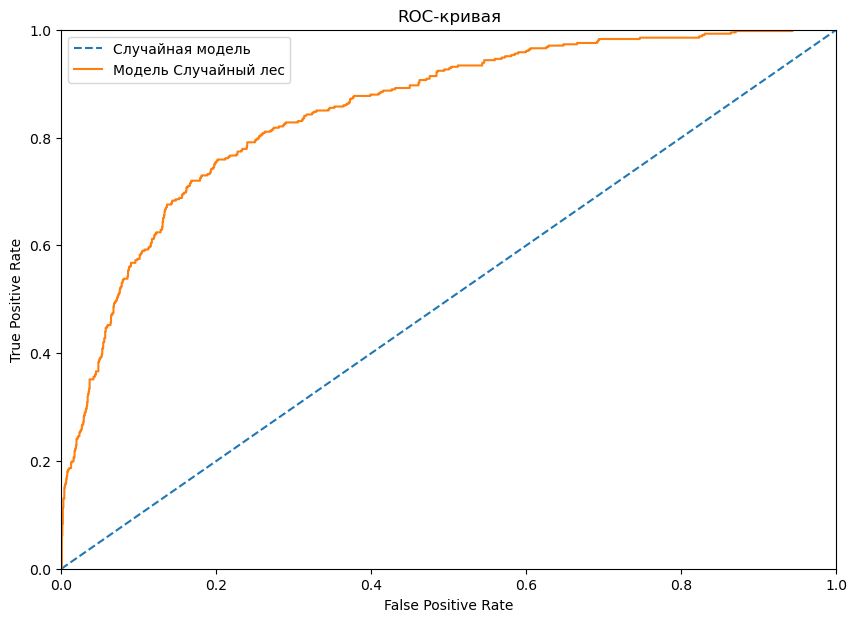

In [50]:
# Построим график ROC-кривой для лучшей модели

plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_rfc_best,tpr_rfc_best)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Модель Случайный лес'),
           loc= 'upper left') 
plt.show()

In [51]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
f1_score(dummy_model.predict(features_test), target_test)

0.3381803074366431

In [52]:
recall_score(target_test, predicted_rfc_best)

0.6756756756756757

**Вывод:**
В результате тестирования модели, которая показала лучшие результат при обучении, мы получили значения `F1 = 0.6097560975609757` и `AUC-ROC = 0.8495660529558835`. Эти показатели соответствуют поставленным задачам этого проекта, хотя очевидно, что наша модель имеет признаки переобучения.
`Recall` или доля клиентов на отток, которых наша модель правильно детектирует, составляет `0.6756756756756757`, что тоже неплохо


## Общий вывод

   Для решения поставленного в начале проекта вопроса, а именно, спрогнозировать уйдет ли клиент в ближайшее время из банка или нет, мы исследовали разные модели машинного обуения. В данных, предоставленных банком, присутствует явный дисбаланс классов. Отношение положительных к отрицательным составляет 1:4. Поэтому были применены разные методы балансировки классов: автобалансировка с помощью гиперпараметра *'balanced'*, увеличение доли объектов редкого класса методом *'upsampling'*, уменьшение выборки методом *'downsampling'*. Также были исследованы модели, обученные при имеющемся дисбалансе классов.
 
   Наилучшие значения показателя F1 (агрегирующей метрики, отражающей среднее гармоническое полноты и точности) показала модель случайного леса. F1 этой модели в сравнении с другими, был выше независимо от выбора метода обучения. Максимальное значение F1 = 0.64984 было у модели случайного леса с увеличенной выборкой.
 
   На тестировании модель выдала значения `F1 = 0.6097560975609757` и `AUC-ROC = 0.8495660529558835`. Эти показатели соответствуют поставленным задачам этого проекта, хотя очевидно, что наша модель имеет признаки переобучения. Также мы посчитали метрику `Recall`(полноту), она составляет `0.6756756756756757` и отражает долю клиентов на отток, которых наша модель правильно детектирует.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*